Notebook to contrast Maximum Likelihood Estimation (MLE) and Score-Based Matching estimation techniques. We try to learn the parameters for 1D Gaussian Distribution. This notebook is based on the seminal work of Hyvarinen et al. https://www.jmlr.org/papers/volume6/hyvarinen05a/hyvarinen05a.pdf

In [22]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import torch
from torch.optim import Adam
from scipy.stats import norm

pi = torch.from_numpy(np.array([np.pi]))

In density estimation problems, our objective is to learn/fit a probability density given $N$ observation from an underlying distirbution $p_x$. However, if we try to learn $p_x$ directly by fitting a model $p_\theta$ (i.e. parametrized by $\theta$), we need to impose 2 additional constraints on the class of functions: $$ \int_x p_\theta(x) dx = 1$$ and $$ p_\theta(x) > 0 \forall x$$ .  \end{align*} These constraints are difficult to incorporate. Howver, note that we can re-express $p_\theta(x)$ as $$p_\theta(x) = \frac{e^{\eta_\theta(x)}}{Z_\theta} $$ and our objective now is to learn $\eta_\theta(x)$. Note that this new objective has no constraints. However, it introduces a new computationally expensive operation which is the computation of the normalization constant $$Z_\theta = \int_{x \in \mathcal{X}}e^{\eta_\theta(x)} dx $$. This is an integral over all the sample space which is obviously expensive to calculate. Although, different techniques to approximate it have been proposed (variational inference etc.), score-based matching estimation circumvent the need to calculate this quantity.

In this notebook, we will look at learning the parameters of a Gaussian distribution given n samples. Note that a Gaussian distribution has the following form: $$p(x ; \mu, \sigma) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{1}{2} (\frac{x - \mu}{\sigma})^2} $$ . If we let $Z_\theta = \frac{1}{\sigma \sqrt{2\pi}}$, then we retrieve back the same form as above

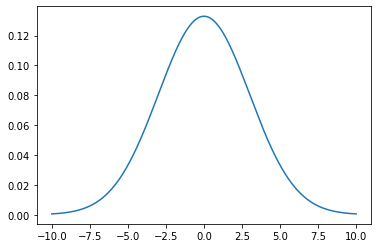

In [26]:
# Start by generating a 1D Gaussian with mean = 0 and std = 3 
n = 1000
x = torch.from_numpy(np.random.normal(loc=0, scale=3, size=n))
x_axis = np.arange(-10, 10, 0.001)
plt.plot(x_axis, norm.pdf(x_axis,0,3))

# Maximum Likelihood Estimation (MLE)

With MLE, we can use the negative log likelihood objective $$-\log (p(x ; \mu, \sigma)) = -\log(\frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{1}{2} (\frac{x - \mu}{\sigma})^2}) =  \frac{1}{2} (\frac{x - \mu}{\sigma})^2 +  \log(\sigma \sqrt{2\pi}) = \frac{1}{2} (\frac{x - \mu}{\sigma})^2 + Z_\theta$$ so the normalizing constant is indeed part of the optimization problem when trying to fit a model using maximum likelihood

In [27]:
def NLLloss(data, std, mean):
    loss = torch.mean( (1/2) * ((x - mean)/std)**2 + torch.log(torch.sqrt(2*pi) * std)  )
    return loss 

Initialize the parameters that we want to train the mean and std $\mu$ and $\sigma$ of the Gaussian and choose whatever optimizer

In [36]:
learning_rate = 0.01
std = torch.nn.Parameter(torch.ones(1,1)).requires_grad_()
mean = torch.nn.Parameter(torch.ones(1,1)).requires_grad_()
params_to_train = [std, mean]
optimizer = Adam(params_to_train, learning_rate)

Now the learning loop for specific number of iterations

In [37]:
for t in range(1000):
    optimizer.zero_grad()
    loss = NLLloss(x, std, mean)
    loss.backward()
    optimizer.step()


mean = 0.005989189725369215, var = 2.859422206878662


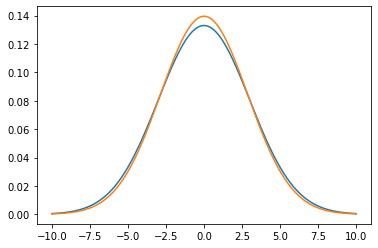

In [43]:
# Plot the "true" underlying distribution and its parameters

x = torch.from_numpy(np.random.normal(loc=0, scale=3, size=n))
x_axis = np.arange(-10, 10, 0.001)
plt.plot(x_axis, norm.pdf(x_axis,0,3))
mean_np = mean.detach().numpy()
std_np = std.detach().numpy()
print("mean = {}, var = {}".format(mean_np[0][0],std_np[0][0]))
plt.plot(x_axis, norm.pdf(x_axis,mean_np[0][0],std_np[0][0]))

# Score-based Matching Fitting

In score-based matching, the we try to match the score of the data distributions. There are few proofs in the paper above but if we let the score be $\phi(x) = \nabla_x log(q(x; \mu, \sigma))$ , then the objective becomes: $$    J(\theta) = \mathbb{E}_{\mathbf{x} \sim p_\mathbf{x}}\left[\sum_i^n \left(\partial_i \phi_i(\mathbf{x}) + \frac{1}{2} \phi_i(\mathbf{x})^2   \right)\right] $$  where $\mathbf{x}\in \mathbb{R}^n$ is the the data vector $\mathbf{x}$ and $ \partial_i \phi_i(\mathbf{x}) $ is the gradient of $\phi(\mathbf{x})$ with respect to the ith coordinate of $\mathbf{x}$. Since we our data comes from a 1D Gaussian, the loss becomes: $$ \mathbb{E}_{x \sim p_\mathbf{x}}\left[\left(\frac{\partial \phi(x)}{\partial x} + \frac{1}{2} \phi(x)^2   \right)\right] = \mathbb{E}_{x \sim p_\mathbf{x}}\left[\left(\frac{\partial^2 log(q(x; \mu, \sigma))}{\partial^2 x} + \frac{1}{2} \left[\frac{\partial log(q(x; \mu, \sigma))}{\partial x}\right]^2   \right)\right]$$

In [44]:
# This is log(q)
def logq(x, mean, std):
    return (-1/2) * ((x - mean)/std)**2

_grad_x implements the gradient of q wrt to data

In [45]:
def _grad_x(logq, mean, std, x):
    x.requires_grad_(True)
    y = logq(x, mean, std) 
    
    # Since logq is a function from R x R^2 to R. y will have the same shape as x (n , 1)
    
    d_output = torch.ones_like(y, requires_grad=False, device=y.device)
    gradients = torch.autograd.grad(
        outputs=y,
        inputs=x,
        grad_outputs=d_output,
        create_graph=True,
        retain_graph=True,
        only_inputs=True)[0]
    return gradients

_hessian_x(logq, mean, std, x) implements the hessian of q wrt to data

In [47]:
def _hessian_x(logq, mean, std, x):
    x.requires_grad_(True)
    y = _grad_x(logq, mean, std, x) 
    d_output = torch.ones_like(y, requires_grad=False, device=y.device)
    gradients = torch.autograd.grad(
        outputs=y,
        inputs=x,
        grad_outputs=d_output,
        create_graph=True,
        retain_graph=True,
        only_inputs=True)[0]
    return gradients

In [53]:
learning_rate = 0.1
std = torch.nn.Parameter(torch.ones(1,1)).requires_grad_()
mean = torch.nn.Parameter(torch.ones(1,1)).requires_grad_()
params_to_train = [std, mean]
optimizer = Adam(params_to_train, learning_rate)

In [54]:
def scoreMatchingLoss(x, grad, hessian):
    loss = torch.mean( hessian + 1/2 * grad**2)
    return loss 


In [55]:
for t in range(1000):
    optimizer.zero_grad()
    grad = _grad_x(logq, mean, std, x)
    hessian =_hessian_x(logq, mean, std, grad)
    loss = scoreMatchingLoss(x, grad, hessian)
    loss.backward()
    optimizer.step()

In [ ]:
# Plot the "true" underlying distribution and its parameters

x = torch.from_numpy(np.random.normal(loc=0, scale=3, size=n))
x_axis = np.arange(-10, 10, 0.001)
plt.plot(x_axis, norm.pdf(x_axis,0,3))
mean_np = mean.detach().numpy()
std_np = std.detach().numpy()
print("mean = {}, var = {}".format(mean_np[0][0],std_np[0][0]))
plt.plot(x_axis, norm.pdf(x_axis,mean_np[0][0],std_np[0][0]))

Note that the objective does NOT depend one the normalization constant. However, we did introduce an additional complication which is the computation of the hessian with respect to data. As the dimentionality of the data and